In [ ]:
#default_exp moco

# MoCo

> [Momentum Contrast for Unsupervised Visual Representation Learning](https://arxiv.org/pdf/1911.05722.pdf) (MoCo)

> [Improved Baselines with Momentum Contrastive Learning](https://arxiv.org/pdf/2003.04297.pdf) (MoCo-v2)

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Data Augmentation

We can use batch data augmentation utilities form `self_supervised.augmentations` module.

In [ ]:
#hide
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))
t = Pipeline([ToTensor(), IntToFloatTensor(), Resize(256)])(img)
type(img), type(t)

(fastai.vision.core.PILImage, fastai.torch_core.TensorImage)

SimCLR augmentations side by side with the original image

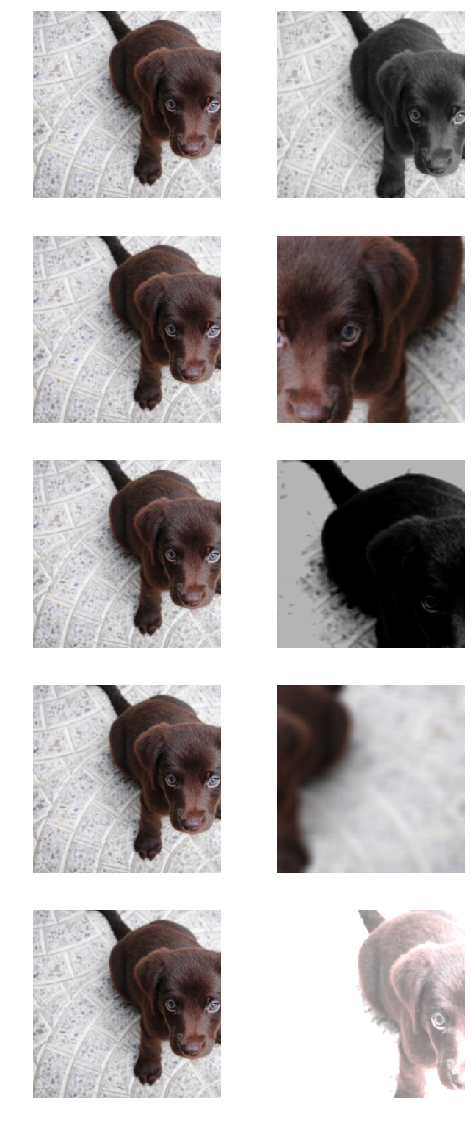

In [ ]:
aug = get_batch_augs(224, cuda=False)
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

## Architecture

![](images/moco.png)

For encoder any PyTorch model which takes an image input and outputs embeddings/representations can be used. You can also use utilities to create encoder from the models defined in `fastai` or `timm` using the following functions: `create_fastai_encoder` and `create_timm_encoder`. Fastai expects a function such as `xresnet18` as first argument whereas timm expects a string like `"tf_efficientnet_b0_ns"`.

In [ ]:
timm_encoder = create_timm_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False)

In [ ]:
L(timm_encoder.named_children())[-4:].itemgot(1)

(#4) [BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),SiLU(inplace=True),SelectAdaptivePool2d (pool_type=catavgmax, flatten=True),Identity()]

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=3, pretrained=False)

In [ ]:
L(fastai_encoder.named_children())[-3:].itemgot(1)

(#3) [Sequential(
  (0): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idpath): Sequential(
      (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (1): ConvLayer(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (act): ReLU(inplace=True)
  )
  (1): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

For creating MLP module aka projector `create_mlp_module` can be used.

In [ ]:
#export
class MoCoModel(Module):
    "MoCo model"
    def __init__(self,encoder,projector): self.encoder,self.projector = encoder,projector
    def forward(self,x): return F.normalize(self.projector(self.encoder(x)), dim=1)

You can either use `MoCoModel` module to create a model by passing predefined `encoder` and `projector` models or you can use `create_moco_model` with just passing predefined encoder and expected input channels. In new MoCo paper, model consists of an encoder and a mlp projector following the SimCLR-v2 improvements, a method which was already introduced in `BYOL`.

Ref: https://github.com/facebookresearch/moco/blob/78b69cafae80bc74cd1a89ac3fb365dc20d157d3/moco/builder.py#L126

In [ ]:
#export
def create_moco_model(encoder, n_in=3, hidden_size=256, projection_size=128):
    "Create MoCo model"
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size) 
    apply_init(projector)
    return MoCoModel(encoder, projector)

In [ ]:
model = create_moco_model(timm_encoder, n_in=3, hidden_size=2048, projection_size=128)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

In [ ]:
out.norm(dim=1)

tensor([1.0000, 1.0000], grad_fn=<CopyBackwards>)

## MoCo Callback

Reference: https://github.com/facebookresearch/moco/blob/master/moco/builder.py

In [ ]:
#export
import copy

class MOCO(Callback):
    order,run_valid = 9,True
    def __init__(self, K, temp=0.07, m=0.999, size=224, aug_func=get_batch_augs, print_augs=False, **aug_kwargs):        
        store_attr("K,temp,m")
        self.aug1 = aug_func(size, **aug_kwargs)
        self.aug2 = aug_func(size, **aug_kwargs)
        if print_augs: print(self.aug1), print(self.aug2)

            
    def before_train(self):
        "Create key encoder and init queue"
        if (not hasattr(self, "encoder_k")) and (not hasattr(self, "queue")):
            # init key encoder
            self.encoder_k = copy.deepcopy(self.learn.model).to(self.dls.device)  
            for param_k in self.encoder_k.parameters(): param_k.requires_grad = False 
            # init queue
            nf = self.learn.model.projector[-1].out_features
            self.queue = torch.randn(self.K, nf)
            self.queue = nn.functional.normalize(self.queue, dim=1)
            self.queue_ptr = 0
        else: raise Exception("Key encoder and queue is already defined")

        self.learn.loss_func = self.lf
        
        
    def before_batch(self):
        "Generate query and key for the current batch"
        q_img,k_img = self.aug1(self.x), self.aug2(self.x.clone())
        self.learn.xb = (q_img,)
        with torch.no_grad(): self.learn.yb = (self.encoder_k(k_img),)

    
    def lf(self, pred, *yb):
        q,k = pred,yb[0]
        logits = q @ torch.cat([k, self.queue]).T / self.temp # Nx(N+K) instead of original Nx(1+K)
        labels = torch.arange(len(q))
        return F.cross_entropy(logits, labels)
            

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.learn.model.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

            
    @torch.no_grad()
    def _dequeue_and_enqueue(self):
        bs = self.x.size(0)
        k = self.y
        assert self.K % bs == 0  # for simplicity
        self.queue[self.queue_ptr:self.queue_ptr+bs, :] = k
        self.queue_ptr = (self.queue_ptr + bs) % self.K  # move pointer

    
    def after_step(self):
        "Update momentum (key) encoder and queue"
        self._momentum_update_key_encoder()
        self._dequeue_and_enqueue()
          
    
    def show(self, n=1):
        x1,x2  = self.aug1(self.x), self.aug2(self.x.clone())
        bs = x1.size(0)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        show_images(images, nrows=n)

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=8, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=1, pretrained=False)
model = create_moco_model(fastai_encoder, n_in=1, hidden_size=1024, projection_size=128)
learn = Learner(dls, model,
                cbs=[MOCO(K=128, rotate=False, jitter=False, bw=False, blur=False,stats=None,cuda=False),
                     ShortEpochCallback(0.001)])

In [ ]:
b = dls.one_batch()
learn._split(b)
# learn('before_batch')
learn.pred = learn.model(*learn.xb)

Display 2 standard resolution crops and 6 additional low resolution crops, aka multi crop

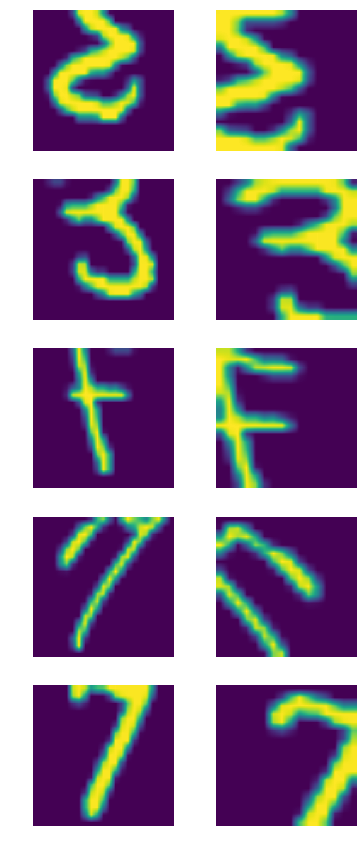

In [ ]:
learn.moco.show(n=5)

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(2.0316)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00-utils.ipynb.
Converted 01-augmentations.ipynb.
Converted 02-layers.ipynb.
Converted 10-simclr.ipynb.
Converted 10b-simclr_v2.ipynb.
Converted 20-byol.ipynb.
Converted 30-swav.ipynb.
Converted index.ipynb.
